# Mars Express Tracking Data Residuals Analysis

This notebook analyzes tracking data residuals from Mars Express during the December 2013 Phobos flyby. We'll compare two tracking systems:

- **IFMS (Closed-loop)**: Traditional ground station tracking from New Norcia
- **FDETS (Open-loop)**: Advanced Doppler observations from HARTRAO and URUMQI

By the end, you'll have computed residuals, visualized the results, and exported the data for further analysis.

## Part 1: Setting Up the Environment

Let's start by importing the tools we need and downloading the mission data from ESA's archives.

In [1]:
import csv
import numpy as np
import random
import os
from datetime import datetime
from collections import defaultdict
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# TudatPy imports for astrodynamics computations
from tudatpy.astro import time_representation
from tudatpy.math import interpolators
from tudatpy.dynamics import environment_setup, environment
from tudatpy.estimation.observations_setup.ancillary_settings import FrequencyBands
from tudatpy.estimation.observable_models_setup import links
from tudatpy.estimation import observable_models_setup, observations_setup, observations
import tudatpy.data as data
from tudatpy.data.mission_data_downloader import *
from tudatpy.interface import spice

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


### Downloading Mars Express Data

We'll download tracking data from ESA's Planetary Science Archive for the period around the Phobos flyby (December 27-31, 2013). This includes:
- **Meteorological data** for atmospheric corrections
- **IFMS tracking files** with closed-loop Doppler measurements

In [ ]:
print("Downloading Mars Express mission data from ESA archives...")

# Initialize data loader
object = LoadPDS()
spice.clear_kernels()

# Mission configuration
input_mission = 'mex'
local_path = './mex_archive'
start_date_mex = datetime(2013, 12, 27)
end_date_mex = datetime(2013, 12, 31)

# Define URLs for meteorological and IFMS data
custom_met_urls = [
    'https://archives.esac.esa.int/psa/ftp/MARS-EXPRESS/MRS/MEX-X-MRS-1-2-3-EXT4-3619-V1.0/CALIB/CLOSED_LOOP/IFMS/MET/',
    'https://archives.esac.esa.int/psa/ftp/MARS-EXPRESS/MRS/MEX-X-MRS-1-2-3-EXT4-3624-V1.0/CALIB/CLOSED_LOOP/IFMS/MET/',
    'https://archives.esac.esa.int/psa/ftp/MARS-EXPRESS/MRS/MEX-X-MRS-1-2-3-EXT4-3628-V1.0/CALIB/CLOSED_LOOP/IFMS/MET/'
]

custom_ifms_urls = [
    'https://archives.esac.esa.int/psa/ftp/MARS-EXPRESS/MRS/MEX-X-MRS-1-2-3-EXT4-3619-V1.0/DATA/LEVEL02/CLOSED_LOOP/IFMS/DP2',
    'https://archives.esac.esa.int/psa/ftp/MARS-EXPRESS/MRS/MEX-X-MRS-1-2-3-EXT4-3624-V1.0/DATA/LEVEL02/CLOSED_LOOP/IFMS/DP2',
    'https://archives.esac.esa.int/psa/ftp/MARS-EXPRESS/MRS/MEX-X-MRS-1-2-3-EXT4-3628-V1.0/DATA/LEVEL02/CLOSED_LOOP/IFMS/DP2'
]

# Download meteorological data
for custom_met_url in custom_met_urls:
    object.add_custom_mission_kernel_url(input_mission, custom_met_url)
    custom_met_pattern = '^(?P<station>M32ICL3L1B)_(?P<type>[A-Z0-9]+)_(?P<date_file>\d+)_(?P<number>\d+)(?P<extension>\.TAB)$'
    object.add_custom_mission_kernel_pattern(input_mission, 'met', custom_met_pattern)
    object.dynamic_download_url_files_single_time(input_mission, local_path, start_date_mex, end_date_mex, custom_met_url)

# Download IFMS data
for custom_ifms_url in custom_ifms_urls:
    object.add_custom_mission_kernel_url(input_mission, custom_ifms_url)
    custom_ifms_pattern = '^(?P<station>M32ICL3L02|M32ICL2L02)_(?P<type>D2X)_(?P<date_file>\d+)_(?P<number>\d+)(?P<extension>\.TAB)$'
    object.add_custom_mission_kernel_pattern(input_mission, 'ifms', custom_ifms_pattern)
    object.dynamic_download_url_files_single_time(input_mission, local_path, start_date_mex, end_date_mex, custom_ifms_url)

print("✓ Data download complete!")

Checking URL: https://archives.esac.esa.int/psa/ftp/MARS-EXPRESS/MRS/MEX-X-MRS-1-2-3-EXT4-3619-V1.0/CALIB/CLOSED_LOOP/IFMS/MET/


### Data Cleaning

IFMS files sometimes contain invalid data points (marked with -999999999). Let's filter these out before processing.

In [ ]:
#def parse_and_filter_file(filename):
#    """Remove invalid data points from IFMS files"""
#    file_path = Path(filename)
#    output_folder = file_path.parent.parent / "ifms_filtered"
#    output_folder.mkdir(parents=True, exist_ok=True)
#
#    df = pd.read_csv(file_path, sep='\s+', header=None)
#    df = df[~df[8].astype(float).between(-1.000000001e9, -999999998.999)]
#
#    output_filename = output_folder / file_path.name
#    df.to_csv(output_filename, sep=" ", index=False, header=False)
#    return output_filename
#
#DOWNLOADED_IFMS_FOLDER = './mex_archive/ifms'
#filtered_count = 0
#for file in os.listdir(DOWNLOADED_IFMS_FOLDER):
#    filtered_file = parse_and_filter_file(os.path.join(DOWNLOADED_IFMS_FOLDER, file))
#    filtered_count += 1
#
#print(f"✓ Filtered {filtered_count} IFMS files")

### Configure Your Analysis

**Important:** Update `BASE_DIR` to match your local directory structure. This is where your SPICE kernels, FDETS data, and other reference files are stored.

In [2]:
# =============================================================================
# USER CONFIGURATION - UPDATE THESE PATHS
# =============================================================================

BASE_DIR = '/Users/lgisolfi/Desktop/mex_phobos_flyby'  # ← Change this to your base directory

# Subdirectories
KERNELS_FOLDER = os.path.join(BASE_DIR, 'kernels')
FDETS_FOLDER = os.path.join(BASE_DIR, 'fdets/complete')
IFMS_FOLDER = './mex_archive/ifms_filtered'
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')

# Reference data
WEATHER_DATA_DIR = './mex_archive/met'
VMF_FILE = os.path.join(BASE_DIR, 'VMF/y2013.vmf3_r.txt')

# Analysis time window
ANALYSIS_START = datetime(2013, 12, 28, 0, 0, 0)
ANALYSIS_END = datetime(2013, 12, 31, 0, 0, 0)

# Mission configuration
SPACECRAFT_NAME = "MEX"
SPACECRAFT_CENTRAL_BODY = "Mars"

# FDETS files to process (these should be in your FDETS_FOLDER)
FDETS_FILES_TO_PROCESS = [
    'Fdets.mex2013.12.28.Ur.complete.r2i.txt',  # Urumqi
    'Fdets.mex2013.12.28.Ht.complete.r2i.txt'   # HARTRAO
]

print(f"✓ Configuration complete")
print(f"  Analysis period: {ANALYSIS_START.date()} to {ANALYSIS_END.date()}")

✓ Configuration complete
  Analysis period: 2013-12-28 to 2013-12-31


### Helper Functions

These utility functions help us organize data by ground station and map station codes to readable names.

In [3]:
def get_weather_files_by_station(weather_data_dir):
    """Group weather files by station code"""
    if not os.path.exists(weather_data_dir):
        print(f"Warning: Weather data directory not found at {weather_data_dir}")
        return {}

    station_files = defaultdict(list)
    for f in os.listdir(weather_data_dir):
        if f.startswith('.'):
            continue

        filename = os.path.basename(f)
        if len(filename) <= 3:
            continue

        station_code = filename[1:3]
        full_path = os.path.join(weather_data_dir, f)

        # Map station codes (60→63, 10→14, etc.)
        if station_code == '60':
            station_files['63'].append(full_path)
        elif station_code == '10':
            station_files['14'].append(full_path)
        elif station_code == '32':
            station_files['32'].append(full_path)

    return dict(station_files)

def get_ifms_files_by_station(ifms_data_dir):
    """Group IFMS files by station code"""
    if not os.path.exists(ifms_data_dir):
        return {}

    station_files = defaultdict(list)
    for f in os.listdir(ifms_data_dir):
        if f.startswith('.'):
            continue

        filename = os.path.basename(f)
        if len(filename) > 3:
            station_code = filename[1:3]
            if station_code in ['63', '14', '32']:
                station_files[station_code].append(os.path.join(ifms_data_dir, f))

    return dict(station_files)

def code_to_site(site_ID):
    """Convert station code to name"""
    mapping = {'32': 'NWNORCIA', '63': 'DSS64', '14': 'DSS14'}
    return mapping.get(site_ID, None)

def ID_to_site(site_ID):
    """Convert FDETS site ID to full station name"""
    mapping = {
        'Ur': 'URUMQI', 'Ht': 'HART15M', 'Hh': 'HARTRAO',
        'Wz': 'WETTZELL', 'On': 'ONSALA60', 'Ys': 'YEBES40M'
        # Add more as needed
    }
    return mapping.get(site_ID, None)

def get_fdets_receiving_station_name(fdets_file):
    """Extract station name from FDETS filename"""
    site_id = os.path.basename(fdets_file).split('.')[4]
    return ID_to_site(site_id)

def generate_random_color():
    """Generate random color for plotting"""
    return "#{:02x}{:02x}{:02x}".format(
        random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
    )

print("✓ Helper functions defined")

✓ Helper functions defined


## Part 2: Creating the Solar System Environment

Now we'll set up the physical environment needed for our analysis. This includes loading SPICE kernels (which contain precise ephemerides) and configuring the celestial bodies.

### Loading SPICE Kernels

SPICE kernels provide precise position and orientation data for spacecraft and celestial bodies. We'll load both standard kernels and Mars Express mission-specific kernels.

In [4]:
print("Loading SPICE kernels...")

# Load standard planetary ephemerides
spice.load_standard_kernels()

# Load Mars Express mission kernels
kernel_count = 0
for kernel in os.listdir(KERNELS_FOLDER):
    if not kernel.startswith('.'):
        kernel_path = os.path.join(KERNELS_FOLDER, kernel)
        spice.load_kernel(kernel_path)
        kernel_count += 1

print(f"✓ Loaded {kernel_count} mission-specific kernels")

Loading SPICE kernels...
✓ Loaded 5 mission-specific kernels


### Defining the Time Window

We'll convert our analysis dates into TudatPy's time format (seconds since J2000 epoch).

In [5]:
start_time = time_representation.Time(
    time_representation.DateTime.to_epoch(
        time_representation.DateTime.from_python_datetime(ANALYSIS_START)
    )
)
end_time = time_representation.Time(
    time_representation.DateTime.to_epoch(
        time_representation.DateTime.from_python_datetime(ANALYSIS_END)
    )
)

start_time_seconds = time_representation.DateTime.to_epoch(
    time_representation.DateTime.from_python_datetime(ANALYSIS_START)
)
end_time_seconds = time_representation.DateTime.to_epoch(
    time_representation.DateTime.from_python_datetime(ANALYSIS_END)
)

print(f"✓ Time window established:")
print(f"  Start: {start_time_seconds:.1f} seconds since J2000")
print(f"  End: {end_time_seconds:.1f} seconds since J2000")

✓ Time window established:
  Start: 441460800.0 seconds since J2000
  End: 441720000.0 seconds since J2000


### Building the Celestial Bodies System

We'll create a system of bodies including the planets needed for accurate gravitational modeling and light-time corrections. We'll also configure Mars Express and the ground stations.

In [6]:
print("Building solar system environment...")

# Define which celestial bodies to include
bodies_to_create = ["Earth", "Sun", "Mercury", "Venus", "Mars", "Jupiter", "Saturn", "Moon"]
global_frame_origin = "SSB"  # Solar System Barycenter
global_frame_orientation = "J2000"

# Create default settings for these bodies
body_settings = environment_setup.get_default_body_settings_time_limited(
    bodies_to_create, start_time, end_time, global_frame_origin, global_frame_orientation
)

# Configure Earth with high-precision rotation model
body_settings.get('Earth').shape_settings = environment_setup.shape.oblate_spherical_spice()
body_settings.get('Earth').rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
    environment_setup.rotation_model.iau_2006, global_frame_orientation,
    interpolators.interpolator_generation_settings(
        interpolators.cubic_spline_interpolation(), start_time, end_time, 3600.0),
    interpolators.interpolator_generation_settings(
        interpolators.cubic_spline_interpolation(), start_time, end_time, 3600.0),
    interpolators.interpolator_generation_settings(
        interpolators.cubic_spline_interpolation(), start_time, end_time, 60.0)
)
body_settings.get('Earth').gravity_field_settings.associated_reference_frame = "ITRS"

print("✓ Earth configured with IAU 2006 rotation model")

Building solar system environment...
✓ Earth configured with IAU 2006 rotation model


### Adding Mars Express Spacecraft

We'll add Mars Express to our system with its ephemeris interpolated from SPICE data.

In [7]:
# Add spacecraft with interpolated ephemeris
body_settings.add_empty_settings(SPACECRAFT_NAME)
body_settings.get(SPACECRAFT_NAME).ephemeris_settings = environment_setup.ephemeris.interpolated_spice(
    start_time, end_time, 10.0, SPACECRAFT_CENTRAL_BODY, global_frame_orientation
)
body_settings.get(SPACECRAFT_NAME).rotation_model_settings = environment_setup.rotation_model.spice(
    global_frame_orientation, SPACECRAFT_NAME + "_SPACECRAFT", ""
)

# Add ground stations
body_settings.get("Earth").ground_station_settings = environment_setup.ground_station.radio_telescope_stations()

# Create the complete system
bodies = environment_setup.create_system_of_bodies(body_settings)

# Configure spacecraft transponder
vehicle_sys = environment.VehicleSystems()
vehicle_sys.set_default_transponder_turnaround_ratio_function()
bodies.get_body(SPACECRAFT_NAME).system_models = vehicle_sys

print("✓ Mars Express spacecraft configured")
print("✓ Ground stations added to Earth")

✓ Mars Express spacecraft configured
✓ Ground stations added to Earth


## Part 3: Processing Tracking Data

Now comes the core analysis. We'll process both IFMS (closed-loop) and FDETS (open-loop) observations, computing residuals between observed and predicted Doppler measurements.

### Setting Up for IFMS Processing

Before processing, we need to configure the antenna position on Mars Express and load weather data for tropospheric corrections.

In [8]:
print("Preparing for IFMS data processing...")

# Initialize results storage
ifms_station_residuals = {}
processed_ifms_count = 0

# Frequency bands used
reception_band = FrequencyBands.x_band
transmission_band = FrequencyBands.x_band

# Get IFMS files
ifms_files = []
if os.path.exists(IFMS_FOLDER):
    for file in os.listdir(IFMS_FOLDER):
        if not file.startswith('.'):
            ifms_files.append(os.path.join(IFMS_FOLDER, file))

print(f"✓ Found {len(ifms_files)} IFMS files to process")

# Configure MEX antenna position (offset from center of mass)
com_position = [-1.3, 0.0, 0.0]
antenna_state = np.zeros((6, 1))
antenna_state[:3, 0] = spice.get_body_cartesian_position_at_epoch(
    "-41020", "-41000", "MEX_SPACECRAFT", "none", start_time
)
antenna_state[:3, 0] = antenna_state[:3, 0] - com_position

antenna_ephemeris_settings = environment_setup.ephemeris.constant(
    antenna_state, "-41000", "MEX_SPACECRAFT"
)
antenna_ephemeris = environment_setup.ephemeris.create_ephemeris(
    antenna_ephemeris_settings, "Antenna"
)

time_scale_converter = time_representation.default_time_scale_converter()

# Load weather data into ground stations
weather_dict = get_weather_files_by_station(WEATHER_DATA_DIR)
for station_code in weather_dict.keys():
    weather_files = weather_dict[station_code]
    data.set_estrack_weather_data_in_ground_stations(bodies, weather_files, code_to_site(station_code))

print("✓ Antenna ephemeris configured")
print("✓ Weather data loaded into ground stations")

Preparing for IFMS data processing...
✓ Found 7 IFMS files to process
✓ Antenna ephemeris configured
✓ Weather data loaded into ground stations


### Processing IFMS and FDETS Files

This is where the heavy lifting happens. For each IFMS file:
1. Load the observations
2. Create observation models with tropospheric corrections
3. Simulate expected observations
4. Compute residuals (observed - simulated)
5. Process corresponding FDETS files if available

This may take a few minutes depending on data volume.

In [9]:
print("Processing IFMS and FDETS data...")
print("This may take several minutes...\n")

# Storage for FDETS results
fdets_station_residuals = {}
processed_fdets_count = 0

# FDETS configuration
base_frequency = 8412e6
column_types = [
    "utc_datetime_string", "signal_to_noise_ratio", "normalised_spectral_max",
    "doppler_measured_frequency_hz", "doppler_noise_hz"
]

# Station name mapping
station_mapping = {
    '14': 'DSS14',
    '63': 'DSS63',
    '32': 'NWNORCIA'
}

# Process each IFMS file
for ifms_idx, ifms_file in enumerate(ifms_files, 1):
    filename = os.path.basename(ifms_file)

    # Extract station code
    if len(filename) <= 3:
        continue
    station_code = filename[1:3]

    if station_code not in station_mapping:
        continue

    transmitting_station_name = station_mapping[station_code]
    print(f"[{ifms_idx}/{len(ifms_files)}] Processing {transmitting_station_name}...")

    # Load IFMS observations
    ifms_collection = observations_setup.observations_wrapper.observations_from_ifms_files(
        [ifms_file], bodies, SPACECRAFT_NAME, transmitting_station_name,
        reception_band, transmission_band
    )

    # Filter by time window
    time_filter = observations.observations_processing.observation_filter(
        observations.observations_processing.ObservationFilterType.time_bounds_filtering,
        start_time, end_time, use_opposite_condition=True
    )

    ifms_collection.filter_observations(time_filter)
    ifms_collection.remove_empty_observation_sets()

    if len(ifms_collection.get_concatenated_observations()) == 0:
        print(f"  No observations in time window, skipping")
        continue

    # Set reference point to antenna
    ifms_collection.set_reference_point(
        bodies, antenna_ephemeris, "Antenna", "MEX", links.retransmitter
    )

    # Configure troposphere corrections
    observable_models_setup.light_time_corrections.set_vmf_troposphere_data(
        [VMF_FILE], True, False, bodies, False, True
    )

    # Define light-time corrections
    light_time_corrections = [
        observable_models_setup.light_time_corrections.first_order_relativistic_light_time_correction(["Sun"]),
        observable_models_setup.light_time_corrections.saastamoinen_tropospheric_light_time_correction()
    ]

    # Create observation models
    doppler_link_ends = ifms_collection.link_definitions_per_observable[
        observable_models_setup.model_settings.dsn_n_way_averaged_doppler_type
    ]

    observation_model_settings = []
    for link_definition in doppler_link_ends:
        observation_model_settings.append(
            observable_models_setup.model_settings.dsn_n_way_doppler_averaged(
                link_definition, light_time_corrections, subtract_doppler_signature=False
            )
        )

    # Create simulators
    observation_simulators = observations_setup.observations_simulation_settings.create_observation_simulators(
        observation_model_settings, bodies
    )

    # Compute residuals
    observations.compute_residuals_and_dependent_variables(
        ifms_collection, observation_simulators, bodies
    )

    # Filter outliers
    residual_filter = observations.observations_processing.observation_filter(
        observations.observations_processing.ObservationFilterType.residual_filtering, 0.1
    )
    ifms_collection.filter_observations(residual_filter)
    ifms_collection.remove_empty_observation_sets()

    if len(ifms_collection.get_concatenated_observations()) == 0:
        print(f"  All observations filtered out, skipping")
        continue

    # Extract results
    times = ifms_collection.get_concatenated_observation_times()
    times_utc = [time_scale_converter.convert_time(
        input_scale=time_representation.tdb_scale,
        output_scale=time_representation.utc_scale,
        input_value=t) for t in times]
    utc_times = [time_representation.DateTime.to_python_datetime(
        time_representation.DateTime.from_epoch(t)) for t in times_utc]

    residuals = ifms_collection.get_concatenated_residuals()
    mean_residuals = ifms_collection.get_mean_residuals()
    rms_residuals = ifms_collection.get_rms_residuals()

    # Store IFMS results
    if transmitting_station_name not in ifms_station_residuals:
        ifms_station_residuals[transmitting_station_name] = {
            'times': [], 'utc_times': [], 'residuals': [], 'mean': [], 'rms': []
        }

    ifms_station_residuals[transmitting_station_name]['times'].extend(times)
    ifms_station_residuals[transmitting_station_name]['utc_times'].extend(utc_times)
    ifms_station_residuals[transmitting_station_name]['residuals'].extend(residuals)
    ifms_station_residuals[transmitting_station_name]['mean'].append(mean_residuals)
    ifms_station_residuals[transmitting_station_name]['rms'].append(rms_residuals)

    processed_ifms_count += 1

    # Define time filter based on IFMS coverage
    start_time_ifms = time_representation.Time(times[0])
    end_time_ifms = time_representation.Time(times[-1])
    time_filter_based_on_ifms = observations.observations_processing.observation_filter(
        observations.observations_processing.ObservationFilterType.time_bounds_filtering,
        start_time_ifms, end_time_ifms, use_opposite_condition=True
    )

    # Process corresponding FDETS files
    for fdets_filename in FDETS_FILES_TO_PROCESS:
        fdets_file = os.path.join(FDETS_FOLDER, fdets_filename)

        if not os.path.exists(fdets_file):
            continue

        site_name = get_fdets_receiving_station_name(fdets_file)
        if site_name is None:
            continue

        # Check if station is available
        available_stations = [station[1] for station in environment_setup.get_ground_station_list(bodies.get_body("Earth"))]
        if site_name not in available_stations:
            continue

        print(f"  Processing FDETS: {site_name}...")

        # Load FDETS observations
        fdets_collection = observations_setup.observations_wrapper.observations_from_fdets_files(
            fdets_file, base_frequency, column_types, SPACECRAFT_NAME,
            transmitting_station_name, site_name, reception_band, transmission_band
        )

        fdets_collection.filter_observations(time_filter_based_on_ifms)
        fdets_collection.remove_empty_observation_sets()

        if len(fdets_collection.get_concatenated_observations()) == 0:
            continue

        # Define link
        link_ends_fdets = {
            links.receiver: links.body_reference_point_link_end_id('Earth', site_name),
            links.retransmitter: links.body_reference_point_link_end_id('MEX', 'Antenna'),
            links.transmitter: links.body_reference_point_link_end_id('Earth', transmitting_station_name),
        }
        link_definition_fdets = links.LinkDefinition(link_ends_fdets)

        fdets_collection.set_reference_point(
            bodies, antenna_ephemeris, "Antenna", "MEX", links.retransmitter
        )

        # Create observation model
        observation_model_settings_fdets = [
            observable_models_setup.model_settings.doppler_measured_frequency(
                link_definition_fdets, light_time_corrections
            )
        ]

        observation_simulators_fdets = observations_setup.observations_simulation_settings.create_observation_simulators(
            observation_model_settings_fdets, bodies
        )

        # Compute residuals
        observations.compute_residuals_and_dependent_variables(
            fdets_collection, observation_simulators_fdets, bodies
        )

        fdets_collection.filter_observations(residual_filter)
        fdets_collection.remove_empty_observation_sets()

        if len(fdets_collection.get_concatenated_observations()) == 0:
            continue

        # Extract FDETS results
        times_fdets = fdets_collection.get_concatenated_observation_times()
        times_utc_fdets = [time_scale_converter.convert_time(
            input_scale=time_representation.tdb_scale,
            output_scale=time_representation.utc_scale,
            input_value=t) for t in times_fdets]
        utc_times_fdets = [time_representation.DateTime.to_python_datetime(
            time_representation.DateTime.from_epoch(t)) for t in times_utc_fdets]

        residuals_fdets = fdets_collection.get_concatenated_residuals()
        mean_residuals_fdets = fdets_collection.get_mean_residuals()
        rms_residuals_fdets = fdets_collection.get_rms_residuals()

        # Store FDETS results
        if site_name not in fdets_station_residuals:
            fdets_station_residuals[site_name] = {
                'times': [], 'utc_times': [], 'residuals': [], 'mean': [], 'rms': [],
                'start_time': [], 'end_time': [], 'transmitting_station': []
            }

        fdets_station_residuals[site_name]['times'].extend(times_fdets)
        fdets_station_residuals[site_name]['utc_times'].extend(utc_times_fdets)
        fdets_station_residuals[site_name]['residuals'].extend(residuals_fdets)
        fdets_station_residuals[site_name]['mean'].append(mean_residuals_fdets)
        fdets_station_residuals[site_name]['rms'].append(rms_residuals_fdets)
        fdets_station_residuals[site_name]['transmitting_station'].append(transmitting_station_name)

        processed_fdets_count += 1

print(f"\n✓ Processing complete!")
print(f"  IFMS files processed: {processed_ifms_count}")
print(f"  FDETS files processed: {processed_fdets_count}")

Processing IFMS and FDETS data...
This may take several minutes...

[1/7] Processing NWNORCIA...
  Processing FDETS: URUMQI...
  Processing FDETS: HART15M...
[2/7] Processing NWNORCIA...


Warning when setting reference point (MEX, Antenna), the reference point already exists. Its ephemeris will be overwritten.

  Processing FDETS: URUMQI...
  Processing FDETS: HART15M...
[3/7] Processing NWNORCIA...


Warning when setting reference point (MEX, Antenna), the reference point already exists. Its ephemeris will be overwritten.

  Processing FDETS: URUMQI...
  Processing FDETS: HART15M...
[4/7] Processing NWNORCIA...
  Processing FDETS: URUMQI...


Warning when setting reference point (MEX, Antenna), the reference point already exists. Its ephemeris will be overwritten.

  Processing FDETS: HART15M...
[5/7] Processing NWNORCIA...
  Processing FDETS: URUMQI...


Warning when setting reference point (MEX, Antenna), the reference point already exists. Its ephemeris will be overwritten.Warning when setting reference point (MEX, Antenna), the reference point already exists. Its ephemeris will be overwritten.

  Processing FDETS: HART15M...


Warning when setting reference point (MEX, Antenna), the reference point already exists. Its ephemeris will be overwritten.

[6/7] Processing NWNORCIA...


Warning when setting reference point (MEX, Antenna), the reference point already exists. Its ephemeris will be overwritten.

  Processing FDETS: URUMQI...


Warning when setting reference point (MEX, Antenna), the reference point already exists. Its ephemeris will be overwritten.

  Processing FDETS: HART15M...


Warning when setting reference point (MEX, Antenna), the reference point already exists. Its ephemeris will be overwritten.

[7/7] Processing NWNORCIA...


Warning when setting reference point (MEX, Antenna), the reference point already exists. Its ephemeris will be overwritten.

  Processing FDETS: URUMQI...


Warning when setting reference point (MEX, Antenna), the reference point already exists. Its ephemeris will be overwritten.

  Processing FDETS: HART15M...

✓ Processing complete!
  IFMS files processed: 7
  FDETS files processed: 6


Warning when setting reference point (MEX, Antenna), the reference point already exists. Its ephemeris will be overwritten.

## Part 4: Visualizing the Results

Now let's see what the residuals look like! We'll create two visualizations:
1. **Full timeline view** - All residuals across the entire analysis period
2. **Detailed subset** - A closer look at a specific time window with distribution plots

### Combined Residuals Plot

This plot shows all IFMS and FDETS observations together. Different stations are color-coded, and you can see the RMS (root-mean-square) value for each station in the legend.

Creating combined residuals visualization...


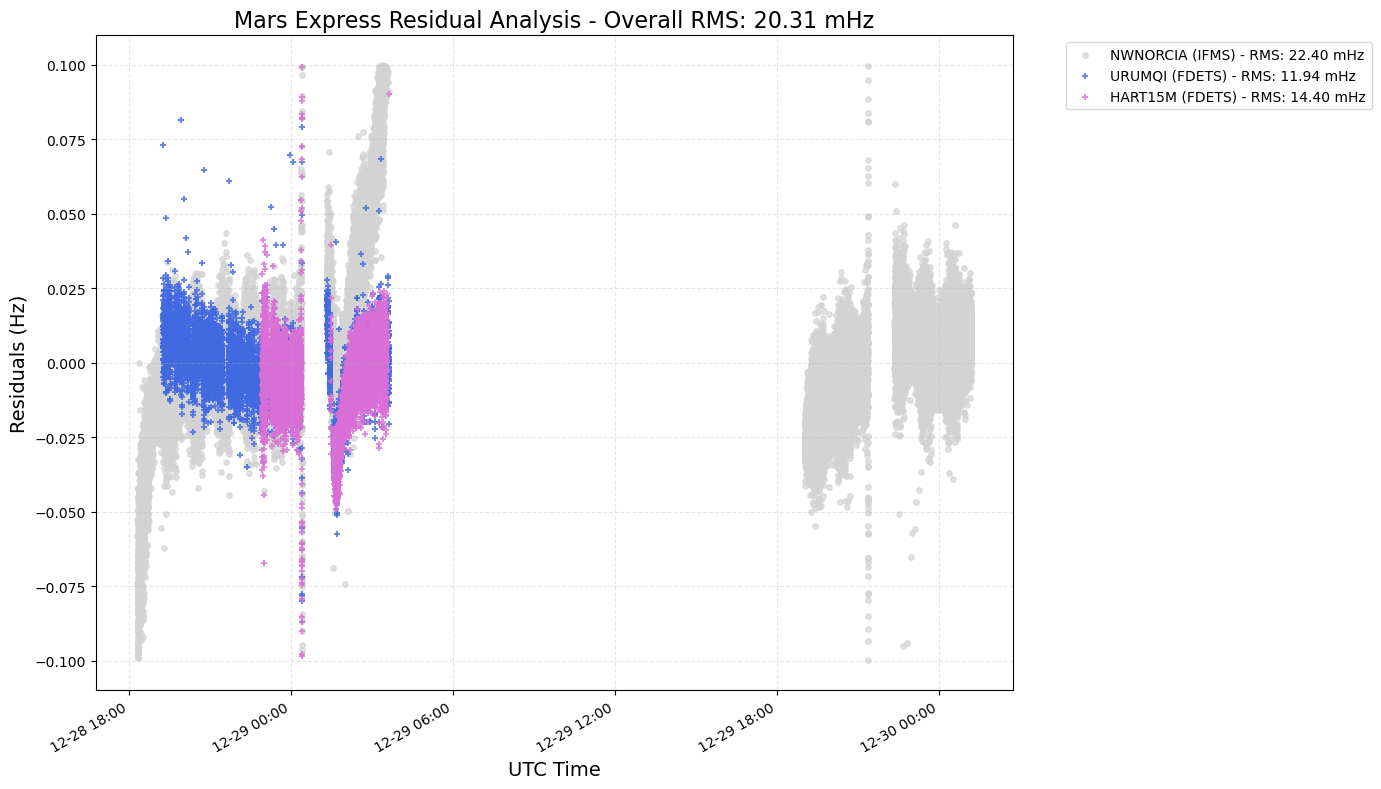

✓ Overall RMS across all stations: 20.31 mHz


In [10]:
print("Creating combined residuals visualization...")

plt.figure(figsize=(14, 8))

# Color scheme for different stations
station_colors = {
    'NWNORCIA': 'lightgray',
    'HART15M': 'orchid',
    'URUMQI': 'royalblue',
    'DSS14': 'red',
    'DSS63': 'green',
    'ONSALA60': 'orange'
}

added_labels = set()
all_residuals = []

# Plot IFMS residuals (circles)
for station_name, ifms_data in ifms_station_residuals.items():
    color = station_colors.get(station_name, generate_random_color())

    utc_times = np.array(ifms_data['utc_times'])
    residuals = np.array(ifms_data['residuals'])
    station_rms = np.sqrt(np.mean(residuals**2))

    plt.scatter(
        utc_times, residuals,
        color=color, marker='o', s=15, alpha=0.7,
        label=f"{station_name} (IFMS) - RMS: {station_rms*1000:.2f} mHz"
        if f"{station_name}_IFMS" not in added_labels else None
    )
    added_labels.add(f"{station_name}_IFMS")
    all_residuals.append(residuals)

# Plot FDETS residuals (plus signs)
for station_name, fdets_data in fdets_station_residuals.items():
    color = station_colors.get(station_name, generate_random_color())

    utc_times = np.array(fdets_data['utc_times'])
    residuals = np.array(fdets_data['residuals'])
    station_rms = np.sqrt(np.mean(residuals**2))

    plt.scatter(
        utc_times, residuals,
        color=color, marker='+', s=20, alpha=0.8,
        label=f"{station_name} (FDETS) - RMS: {station_rms*1000:.2f} mHz"
        if f"{station_name}_FDETS" not in added_labels else None
    )
    added_labels.add(f"{station_name}_FDETS")
    all_residuals.append(residuals)

# Calculate and display overall statistics
if all_residuals:
    all_residuals_array = np.concatenate([np.array(r) for r in all_residuals])
    overall_rms = np.sqrt(np.mean(all_residuals_array**2))

    plt.xlabel("UTC Time", fontsize=14)
    plt.ylabel("Residuals (Hz)", fontsize=14)
    plt.title(f"Mars Express Residual Analysis - Overall RMS: {overall_rms*1000:.2f} mHz", fontsize=16)
    plt.grid(True, linestyle="--", alpha=0.3)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
    plt.gcf().autofmt_xdate()

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print(f"✓ Overall RMS across all stations: {overall_rms*1000:.2f} mHz")
else:
    print("⚠ No residual data available for plotting")

### Focused Analysis: Subset with Distribution

Let's zoom in on a specific time window to see the residuals in more detail. The left panel shows the time series, while the right panel shows the distribution of residuals for each station.

Creating subset analysis for:
  2013-12-28 19:00:00 to 2013-12-29 00:00:00


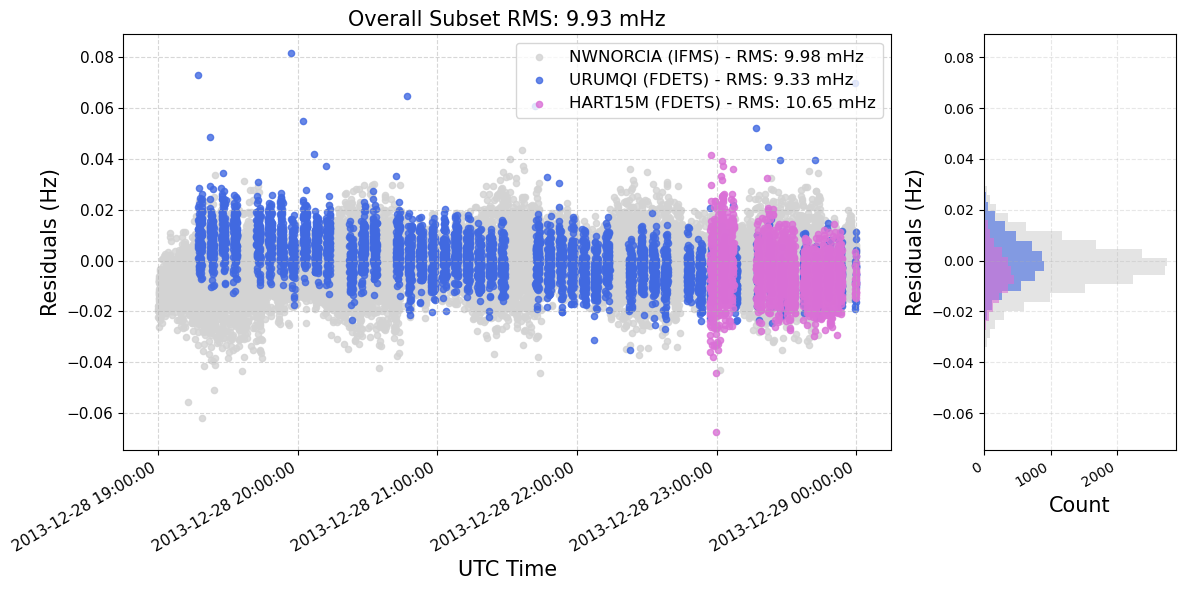

✓ Subset RMS: 9.93 mHz


In [11]:
# Define a focused time window (adjust these as needed)
ANALYSIS_TO_AVOID_START_SCAN = datetime(2013, 12, 28, 19, 0, 0)
ANALYSIS_TO_AVOID_END_SCAN = datetime(2013, 12, 29, 0, 0)

print(f"Creating subset analysis for:")
print(f"  {ANALYSIS_TO_AVOID_START_SCAN} to {ANALYSIS_TO_AVOID_END_SCAN}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [4, 1]})
ax_main, ax_hist = axes

added_labels = set()
subset_all_residuals = []

# Plot IFMS residuals for subset
for station_name, ifms_data in ifms_station_residuals.items():
    color = station_colors.get(station_name, generate_random_color())

    utc_times = np.array(ifms_data['utc_times'])
    residuals = np.array(ifms_data['residuals'])

    # Filter to subset time window
    mask = (utc_times >= ANALYSIS_TO_AVOID_START_SCAN) & (utc_times <= ANALYSIS_TO_AVOID_END_SCAN)
    subset_times = utc_times[mask]
    subset_residuals = residuals[mask]

    if len(subset_residuals) == 0:
        continue

    station_rms = np.sqrt(np.mean(subset_residuals**2))

    # Time series plot
    ax_main.scatter(
        subset_times, subset_residuals,
        color=color, marker='o', s=20, alpha=0.8,
        label=f"{station_name} (IFMS) - RMS: {station_rms*1000:.2f} mHz"
        if f"{station_name}_IFMS" not in added_labels else None
    )
    added_labels.add(f"{station_name}_IFMS")
    subset_all_residuals.append(subset_residuals)

    # Distribution histogram
    ax_hist.hist(
        subset_residuals,
        bins=30,
        orientation='horizontal',
        alpha=0.6,
        color=color
    )

# Plot FDETS residuals for subset
for station_name, fdets_data in fdets_station_residuals.items():
    color = station_colors.get(station_name, generate_random_color())

    utc_times = np.array(fdets_data['utc_times'])
    residuals = np.array(fdets_data['residuals'])

    mask = (utc_times >= ANALYSIS_TO_AVOID_START_SCAN) & (utc_times <= ANALYSIS_TO_AVOID_END_SCAN)
    subset_times = utc_times[mask]
    subset_residuals = residuals[mask]

    if len(subset_residuals) == 0:
        continue

    station_rms = np.sqrt(np.mean(subset_residuals**2))

    ax_main.scatter(
        subset_times, subset_residuals,
        color=color, marker='o', s=20, alpha=0.8,
        label=f"{station_name} (FDETS) - RMS: {station_rms*1000:.2f} mHz"
        if f"{station_name}_FDETS" not in added_labels else None
    )
    added_labels.add(f"{station_name}_FDETS")
    subset_all_residuals.append(subset_residuals)

    ax_hist.hist(
        subset_residuals,
        bins=30,
        orientation='horizontal',
        alpha=0.6,
        color=color
    )

# Format plots
if subset_all_residuals:
    all_subset_residuals_array = np.concatenate([np.array(r) for r in subset_all_residuals])
    overall_subset_rms = np.sqrt(np.mean(all_subset_residuals_array**2))

    ax_main.set_xlabel("UTC Time", fontsize=15)
    ax_main.set_ylabel("Residuals (Hz)", fontsize=15)
    ax_main.set_title(f"Overall Subset RMS: {overall_subset_rms*1000:.2f} mHz", fontsize=15)
    ax_main.grid(True, linestyle="--", alpha=0.5)
    ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    ax_main.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax_main.tick_params(axis='x', labelsize=11)
    ax_main.tick_params(axis='y', labelsize=11)
    ax_main.legend(fontsize=12)

    ax_hist.set_xlabel("Count", fontsize=15)
    ax_hist.set_ylabel("Residuals (Hz)", fontsize=15)
    ax_hist.grid(True, linestyle='--', alpha=0.3)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    print(f"✓ Subset RMS: {overall_subset_rms*1000:.2f} mHz")
else:
    print("⚠ No subset data available for plotting")

## Part 5: Exporting Results

Finally, let's save all our computed residuals to CSV files for further analysis or sharing with colleagues.

In [12]:
print("Exporting results to CSV files...")

# Create output directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
ifms_output_dir = os.path.join(OUTPUT_DIR, 'ifms_residuals')
fdets_output_dir = os.path.join(OUTPUT_DIR, 'fdets_residuals')
os.makedirs(ifms_output_dir, exist_ok=True)
os.makedirs(fdets_output_dir, exist_ok=True)

# Export IFMS residuals
ifms_files_created = 0
for station_name, data in ifms_station_residuals.items():
    filename = f"{station_name}_residuals_ifms.csv"
    file_path = os.path.join(ifms_output_dir, filename)

    with open(file_path, mode="w", newline="") as file:
        writer = csv.writer(file)

        # Write header with metadata
        writer.writerow([f'# Station: {station_name}'])
        writer.writerow(['# Data Type: IFMS (Closed-Loop)'])
        writer.writerow(['# Time (seconds since J2000)', 'UTC Time', 'Residuals (Hz)'])

        # Write data rows
        times = data['times']
        utc_times = data['utc_times']
        residuals = data['residuals']

        for time, utc_time, residual in zip(times, utc_times, residuals):
            writer.writerow([
                f"{time:.6f}",
                utc_time.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3],
                f"{residual:.8e}"
            ])

    ifms_files_created += 1

print(f"✓ Created {ifms_files_created} IFMS CSV files in {ifms_output_dir}")

# Export FDETS residuals
fdets_files_created = 0
for station_name, data in fdets_station_residuals.items():
    filename = f"{station_name}_residuals_fdets.csv"
    file_path = os.path.join(fdets_output_dir, filename)

    with open(file_path, mode="w", newline="") as file:
        writer = csv.writer(file)

        # Write header with metadata
        writer.writerow([f'# Station: {station_name}'])
        writer.writerow(['# Data Type: FDETS (Open-Loop)'])
        writer.writerow(['# Time (seconds since J2000)', 'UTC Time', 'Residuals (Hz)', 'Transmitting Station'])

        # Write data rows
        times = data['times']
        utc_times = data['utc_times']
        residuals = data['residuals']
        transmitting_stations = data.get('transmitting_station', ['Unknown'] * len(times))

        for i, (time, utc_time, residual) in enumerate(zip(times, utc_times, residuals)):
            tx_station = transmitting_stations[min(i, len(transmitting_stations)-1)] if transmitting_stations else 'Unknown'

            writer.writerow([
                f"{time:.6f}",
                utc_time.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3],
                f"{residual:.8e}",
                tx_station
            ])

    fdets_files_created += 1

print(f"✓ Created {fdets_files_created} FDETS CSV files in {fdets_output_dir}")
print(f"\n{'='*60}")
print(f"Analysis Complete!")
print(f"{'='*60}")
print(f"Total output directory: {OUTPUT_DIR}")
print(f"You can now use these CSV files for further analysis.")

Exporting results to CSV files...
✓ Created 1 IFMS CSV files in /Users/lgisolfi/Desktop/mex_phobos_flyby/output/ifms_residuals
✓ Created 2 FDETS CSV files in /Users/lgisolfi/Desktop/mex_phobos_flyby/output/fdets_residuals

Analysis Complete!
Total output directory: /Users/lgisolfi/Desktop/mex_phobos_flyby/output
You can now use these CSV files for further analysis.
